# Remap MCS mask from non-global lat/lon grid to global HEALPix grid

## Author:
- Zhe Feng || zhe.feng@pnnl.gov

In [1]:
import numpy as np
import xarray as xr
import dask.array as da
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## HEALPix Specific
import healpix as hp
import easygems.healpix as egh
import intake     # For catalogs

In [2]:
intake.__version__

'0.7.0'

In [3]:
xr.__version__

'2025.3.0'

## Reading HEALPix Catalog

In [4]:
# Final location (once updated)
catfn='https://digital-earths-global-hackathon.github.io/catalog/catalog.yaml'
# Interim Repo location
catfn='https://raw.githubusercontent.com/digital-earths-global-hackathon/catalog/refs/heads/scream-final2/catalog.yaml'

scream_cat = intake.open_catalog(catfn)

print (list (scream_cat)) 

['EU', 'NERSC', 'online']


In [5]:
# List different 'types' of data
print (list (scream_cat.NERSC)) 
print (list (scream_cat.online))

['scream2D_hrly', 'scream_ne120', 'scream_lnd']
['ERA5', 'JRA3Q', 'MERRA2', 'icon_ngc4008', 'um_glm_n2560_RAL3p3', 'um_glm_n1280_GAL9', 'um_glm_n1280_CoMA9', 'um_CTC_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SAmer_km4p4_RAL3P3_n1280_GAL9_nest', 'um_Africa_km4p4_RAL3P3_n1280_GAL9_nest', 'um_SEA_km4p4_RAL3P3_n1280_GAL9_nest']


In [6]:
# Show meta data for a specific dataset
scream_cat['NERSC']['scream2D_hrly'].describe()

{'name': 'scream2D_hrly',
 'container': 'xarray',
 'plugin': ['zarr'],
 'driver': ['zarr'],
 'description': '',
 'direct_access': 'forbid',
 'user_parameters': [{'name': 'zoom',
   'description': 'zoom resolution of the dataset',
   'type': 'int',
   'allowed': [10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0],
   'default': 2}],
 'metadata': {'project': 'global_hackathon',
  'experiment_id': 'dyamond3',
  'source_id': 'SCREAM',
  'simulation_id': 'cess-control.ne1024pg2_ne1024pg2.F2010-SCREAMv1.cess-oct2',
  'time_start': datetime.datetime(2019, 8, 1, 0, 0),
  'time_end': datetime.datetime(2020, 9, 1, 0, 0)},
 'args': {'chunks': None,
  'consolidated': True,
  'urlpath': '/global/cfs/cdirs/m4581/gsharing/hackathon/scream-cess-healpix/scream2D_hrly_*_hp{{ zoom }}_v7.zarr'}}

In [7]:
%%time
# Get OLR/precip data from catalog
catalog_params = {'zoom':9}  # Can have multiple parameters
# Note the use of **catalog_params to pass the parameters
ds_hp = scream_cat['NERSC']['scream2D_hrly'](**catalog_params).to_dask()
# ds_hp = scream_cat['NERSC']['scream2D_hrly'](zoom=9).to_dask()
ds_hp

CPU times: user 257 ms, sys: 150 ms, total: 407 ms
Wall time: 622 ms


/global/common/software/m1867/python/hackathon/lib/python3.12/site-packages/intake_xarray/base.py:21: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  'dims': dict(self._ds.dims),


<xarray.Dataset> Size: 238GB
Dimensions:  (crs: 0, time: 9457, cell: 3145728)
Coordinates:
  * crs      (crs) float64 0B 
  * time     (time) object 76kB 2019-08-01 00:00:00 ... 2020-09-01 00:00:00
Dimensions without coordinates: cell
Data variables:
    pr       (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
    rlut     (time, cell) float32 119GB dask.array<chunksize=(24, 262144), meta=np.ndarray>
Attributes: (12/22)
    Conventions:                  CF-1.8
    atm_initial_conditions_file:  /lustre/orion/cli115/world-shared/e3sm/inpu...
    averaging_frequency:          1
    averaging_frequency_units:    nhours
    averaging_type:               INSTANT
    case:                         cess-control.ne1024pg2_ne1024pg2.F2010-SCRE...
    ...                           ...
    product:                      model-output
    realm:                        atmos
    run_t0:                       2019-08-01-00000
    source:                       E3SM Atmosphere Model (EAMxx)
    topography_file:              /lustre/orion/cli115/world-shared/e3sm/inpu...
    username:                     noel

## Reading MCS mask data from PyFLEXTRKR on a lat/lon grid
- lon: -180° to +180° (actual grid: -179.9° to +179.9° with 0.01° resolution)
- lat: -60° to +60° (actual grid: -59.95° to -59.95° with 0.01° resolution)

In [8]:
# Zoom level; resolution
# s='10' ; dkm='6'
s='9' ; dkm='12'
res = ' ('+dkm+'km)'

# MCS lat/lon mask Zarr file directory
# root_dir = '/pscratch/sd/w/wcmca1/scream-cess-healpix/'
root_dir = '/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/'
mask_dir = f'{root_dir}mcs_tracking_hp{s}/mcstracking/'
in_mask_dir = f'{mask_dir}mcs_mask_latlon_20190901.0000_20200901.0000.zarr'
print(in_mask_dir)

/global/cfs/cdirs/m4581/gsharing/hackathon/tracking/mcs/scream/mcs_tracking_hp9/mcstracking/mcs_mask_latlon_20190901.0000_20200901.0000.zarr


In [9]:
# Get chunk size from config
chunksize_time = 24
chunksize_cell = "auto"

# Read mask data
mask_chunks = {"time": min(100, chunksize_time), "lat": "auto", "lon": "auto"}

In [10]:
# Read mask data
ds_mask = xr.open_dataset(in_mask_dir, engine='zarr', chunks=mask_chunks)
ds_mask

<xarray.Dataset> Size: 301GB
Dimensions:   (lat: 1200, lon: 3600, time: 8713)
Coordinates:
  * lat       (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * lon       (lon) float64 29kB -179.9 -179.8 -179.8 ... 179.8 179.8 179.9
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
Data variables:
    mcs_mask  (time, lat, lon) float64 301GB dask.array<chunksize=(24, 480, 1200), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

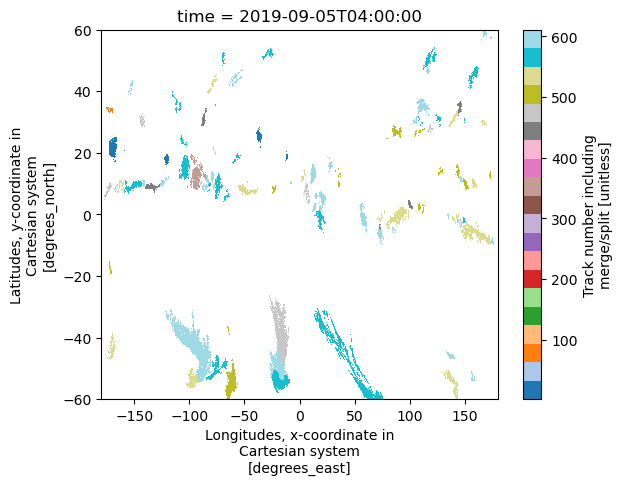

In [11]:
# Select mask at a specific time slice
mcs_mask = ds_mask.mcs_mask.isel(time=100)

mcs_mask.where(mcs_mask>0).plot(cmap="tab20")

##  Remap MCS mask to HEALPix grid

Use `healpix.pix2ang` to transform the MCS mask back to the HEALPix grid format

In [12]:
ds_hp.crs.healpix_nside, ds_hp.crs.healpix_order, ds_hp.cell

(512,
 'nest',
 <xarray.DataArray 'cell' (cell: 3145728)> Size: 25MB
 array([      0,       1,       2, ..., 3145725, 3145726, 3145727])
 Dimensions without coordinates: cell)

In [13]:
%%time
# Make remap lat/lon for HEALPix
remap_lons, remap_lats = hp.pix2ang(
    ds_hp.crs.healpix_nside, ds_hp.cell, nest=ds_hp.crs.healpix_order, lonlat=True,
)
remap_lons = remap_lons % 360
remap_lons.shape, remap_lats.shape

CPU times: user 154 ms, sys: 24.7 ms, total: 178 ms
Wall time: 178 ms


((3145728,), (3145728,))

In [14]:
remap_lons.min(), remap_lons.max()

(np.float64(0.0), np.float64(359.912109375))

In [15]:
# Can create cell coordinate this way, it's the same as ds_hp.cell
cells = np.arange(12 * ds_hp.crs.healpix_nside**2)

# Convert to DataArray
lon_hp = xr.DataArray(remap_lons, dims="cell").assign_coords(cell=ds_hp.cell, lon_hp=lambda da: da)
lat_hp = xr.DataArray(remap_lats, dims="cell").assign_coords(cell=ds_hp.cell, lat_hp=lambda da: da)
lat_hp

<xarray.DataArray (cell: 3145728)> Size: 25MB
array([ 0.0746039 ,  0.14920793,  0.14920793, ..., -0.14920793,
       -0.14920793, -0.0746039 ])
Coordinates:
  * cell     (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lat_hp   (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746

In [16]:
np.max(ds_hp.cell.values - cells)

np.int64(0)

### Function to fix the coordinates of the lat/lon mask DataSet
    1. Convert longitude from -180/+180 to 0-360 range
    2. Roll dataset to start at longitude 0
    3. Ensure coordinates are in ascending order

- Following codes from Tobias Kölling (<tobias.koelling@mpimet.mpg.de>)

In [17]:
def fix_coords(ds, lat_dim="lat", lon_dim="lon"):
    """
    Fix coordinates in a dataset:
    1. Convert longitude from -180/+180 to 0-360 range
    2. Roll dataset to start at longitude 0
    3. Ensure coordinates are in ascending order
    
    Parameters:
    -----------
    ds : xarray.Dataset or xarray.DataArray
        Dataset with lat/lon coordinates
    lat_dim : str, optional
        Name of latitude dimension, default "lat"
    lon_dim : str, optional
        Name of longitude dimension, default "lon"
        
    Returns:
    --------
    xarray.Dataset or xarray.DataArray
        Dataset with fixed coordinates
    """
    # Find where longitude crosses from negative to positive (approx. where lon=0)
    lon_0_index = (ds[lon_dim] < 0).sum().item()
    
    # Create indexers for the roll
    lon_indices = np.roll(np.arange(ds.sizes[lon_dim]), -lon_0_index)
    
    # Roll dataset and convert longitudes to 0-360 range
    ds = ds.isel({lon_dim: lon_indices})
    lon360 = xr.where(ds[lon_dim] < 0, ds[lon_dim] + 360, ds[lon_dim])
    ds = ds.assign_coords({lon_dim: lon360})
    
    # Ensure latitude and longitude are in ascending order if needed
    if np.all(np.diff(ds[lat_dim].values) < 0):
        ds = ds.isel({lat_dim: slice(None, None, -1)})
    if np.all(np.diff(ds[lon_dim].values) < 0):
        ds = ds.isel({lon_dim: slice(None, None, -1)})
    
    return ds

In [18]:
#%% limit extrapolation distance
tolerance = 0.1  # [degree]
def is_valid(ds):
    return (np.abs(ds.lat - ds.lat_hp) < tolerance) & (np.abs(ds.lon - ds.lon_hp) < tolerance)

In [19]:
# Apply function to fix MCS mask dataset coordinates
ds_mask.pipe(fix_coords)

<xarray.Dataset> Size: 301GB
Dimensions:   (lat: 1200, time: 8713, lon: 3600)
Coordinates:
  * lat       (lat) float64 10kB -59.95 -59.85 -59.75 ... 59.75 59.85 59.95
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
  * lon       (lon) float64 29kB 0.05 0.15 0.25 0.35 ... 359.6 359.8 359.9 359.9
Data variables:
    mcs_mask  (time, lat, lon) float64 301GB dask.array<chunksize=(24, 480, 1200), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

In [20]:
%%time
# Remap mask DataSet to HEALPix
ds_mask_hp = ds_mask.pipe(fix_coords).sel(lon=lon_hp, lat=lat_hp, method="nearest").where(is_valid)
ds_mask_hp

CPU times: user 1.36 s, sys: 286 ms, total: 1.64 s
Wall time: 1.65 s


<xarray.Dataset> Size: 219GB
Dimensions:   (time: 8713, cell: 3145728)
Coordinates:
    lat       (cell) float64 25MB 0.05 0.15 0.15 0.25 ... -0.15 -0.15 -0.05
  * time      (time) datetime64[ns] 70kB 2019-09-01 ... 2020-09-01
    lon       (cell) float64 25MB 45.05 45.05 44.95 45.05 ... 315.1 314.9 315.1
  * cell      (cell) int64 25MB 0 1 2 3 4 ... 3145724 3145725 3145726 3145727
    lon_hp    (cell) float64 25MB 45.0 45.09 44.91 45.0 ... 315.1 314.9 315.0
    lat_hp    (cell) float64 25MB 0.0746 0.1492 0.1492 ... -0.1492 -0.0746
Data variables:
    mcs_mask  (time, cell) float64 219GB dask.array<chunksize=(24, 576000), meta=np.ndarray>
Attributes: (12/14)
    Contact:                   Zhe Feng: zhe.feng@pnnl.gov
    Created_on:                Sun Apr 13 20:42:50 2025
    Institution:               Pacific Northwest National Laboratory
    Title:                     Pixel-level feature tracking data
    linkpf:                    1
    minimum_cloud_area:        800
    ...                        ...
    pf_link_area_thresh:       648.0
    pf_smooth_window:          5
    tb_threshold_coldanvil:    241.0
    tb_threshold_core:         225.0
    tb_threshold_environment:  261.0
    tb_threshold_warmanvil:    261.0

### Visualize the MCS masks

Text(0.5, 1.0, 'PyFLEXTRKR SCREAM MCS lat/lon')

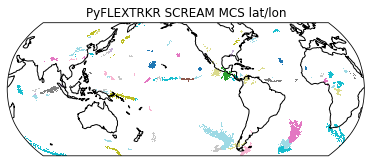

In [21]:
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)}, dpi=72)
mcs_mask = ds_mask.isel(time=100)['mcs_mask']
# Note: imshow does not consider lat/lon coordinates and may flip the image if 
# latitude is in ascending order. Use pcolormesh or contourf instead.

# Use Xarray pcolormesh
mcs_mask.plot(
    ax=ax, 
    vmin=284, vmax=607, cmap="tab20",
    transform=ccrs.PlateCarree(), add_colorbar=False,
)
# Setting extent explicitly doesn't seem to display full global view correctly
# ax.set_extent((0, 360, -90, 90), crs=ccrs.PlateCarree())
ax.coastlines()

plt.title("PyFLEXTRKR SCREAM MCS lat/lon")

Text(0.5, 1.0, 'PyFLEXTRKR SCREAM MCS healpix')

<Figure size 640x480 with 0 Axes>

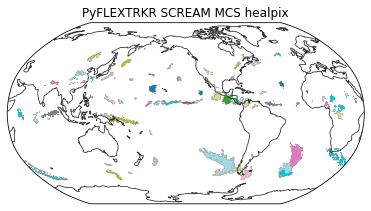

In [22]:
mcs_mask_hp = ds_mask_hp.isel(time=100)['mcs_mask']

img = egh.healpix_show(mcs_mask_hp.where(mcs_mask_hp!=0), vmin=284, vmax=607, cmap="tab20", dpi=72)
plt.title("PyFLEXTRKR SCREAM MCS healpix")